<a href="https://colab.research.google.com/github/ScoomenstheMumens/QiskitThesis-LGTQuantumSimulations/blob/main/GEM_fm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
!pip install retworkx
!pip install Qiskit
!pip install qiskit_nature
!pip install qiskit_ignis
!pip install qiskit-ibm-runtime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [176]:
import numpy as np
import random
from time import time
from qiskit.providers.aer import QasmSimulator, Aer
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator,
                                Sampler as RuntimeSampler)

from qiskit import Aer

from qiskit.algorithms.optimizers import SPSA,COBYLA,L_BFGS_B,SLSQP

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from qiskit.primitives import Estimator,Sampler,BackendSampler,BackendEstimator
import retworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
from qiskit.algorithms import NumPyEigensolver

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter,ParameterVector

from qiskit import IBMQ

from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.circuit import Gate, Instruction, Parameter,ParameterVector

from util import GEM_calibration_circuits,qiskit_calibration_circuits,occurrences_to_vector,DecimalToBinary
from itselfmiti import bin_list
from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit.result import marginal_counts

from qiskit.opflow import X, Z, I,Y
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
import copy


In [177]:
qubits=[0,1]
shots=10000

In [251]:
# Get fake backend if you like
from qiskit.providers.fake_provider import FakeManila

# Noisy simulator backend
device_backend = FakeManila()
#noise_model = NoiseModel.from_backend(device_backend)
#IBMQ.disable_account()
#provider = IBMQ.enable_account('c0df7c866f628346a4ad9eb0955b0b9e8ffedc7dc25fa33a87a59e50864c059fa00f211c7f611efee085a4b810646179209cc819b26a4903c733466bb8b96f51')
IBMQ.update_account()
print(IBMQ.providers())


provider = IBMQ.get_provider(hub='ibm-q',
                            group='open', 
                            project='main')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_manila'))
backend_real_jakarta = provider.get_backend('ibmq_manila')
backend_sim_ideal = Aer.get_backend('aer_simulator')
BACKEND = backend_sim_noisy_jakarta

Found 0 credentials.
No credentials available for updating could be found. No action will be performed.
[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='qc-fall-22-8', group='group-2', project='recrQvTQ0hTCoLumW')>]


In [179]:
def sym_ans_a(num_qubits):
  qr_sym= QuantumRegister(num_qubits)
  qc_sym = QuantumCircuit(qr_sym)

  theta = ParameterVector("t",3*int(round(num_qubits/2-0.1,0)))
  index=0
  for j in range(0,int(round(num_qubits/2-0.1,0))):
    qc_sym.h(qr_sym[j*2])
    qc_sym.rz(theta[index],qr_sym[j*2+1])
    index+=1
    qc_sym.cx(qr_sym[j*2],qr_sym[j*2+1])
    qc_sym.ry(theta[index],qr_sym[j*2])
    qc_sym.ry(theta[index],qr_sym[j*2+1])
    index+=1
    qc_sym.cx(qr_sym[j*2],qr_sym[j*2+1])
    qc_sym.h(qr_sym[j*2])
    qc_sym.rz(theta[index],qr_sym[j*2+1])
    index+=1
  return qc_sym

In [180]:
qc=sym_ans_a(5)
qc.draw()

┌───┐         ┌──────────┐        ┌───┐    
q2095_0: ───┤ H ├──────■──┤ Ry(t[1]) ├──■─────┤ H ├────
         ┌──┴───┴───┐┌─┴─┐├──────────┤┌─┴─┐┌──┴───┴───┐
q2095_1: ┤ Rz(t[0]) ├┤ X ├┤ Ry(t[1]) ├┤ X ├┤ Rz(t[2]) ├
         └──┬───┬───┘└───┘├──────────┤└───┘└──┬───┬───┘
q2095_2: ───┤ H ├──────■──┤ Ry(t[4]) ├──■─────┤ H ├────
         ┌──┴───┴───┐┌─┴─┐├──────────┤┌─┴─┐┌──┴───┴───┐
q2095_3: ┤ Rz(t[3]) ├┤ X ├┤ Ry(t[4]) ├┤ X ├┤ Rz(t[5]) ├
         └──────────┘└───┘└──────────┘└───┘└──────────┘
q2095_4: ──────────────────────────────────────────────

In [181]:
def sym_ans_b(num_qubits):
  qr_sym= QuantumRegister(num_qubits)
  qc_sym = QuantumCircuit(qr_sym)
  if(num_qubits % 2==1):
    theta = ParameterVector("t",3*int(round(num_qubits/2-0.1,0)))
  else:
    theta = ParameterVector("t",3*(int(round(num_qubits/2-0.1,0))-1))
  index=0
  if(num_qubits % 2==1):
    for j in range(0,int(round(num_qubits/2-0.1,0))):
      qc_sym.h(qr_sym[j*2+1])
      qc_sym.rz(theta[index],qr_sym[j*2+2])
      index+=1
      qc_sym.cx(qr_sym[j*2+1],qr_sym[j*2+2])
      qc_sym.ry(theta[index],qr_sym[j*2+1])
      qc_sym.ry(theta[index],qr_sym[j*2+2])
      index+=1
      qc_sym.cx(qr_sym[j*2+1],qr_sym[j*2+2])
      qc_sym.h(qr_sym[j*2+1])
      qc_sym.rz(theta[index],qr_sym[j*2+2])
      index+=1
  else:
    for j in range(0,int(round(num_qubits/2-0.1,0))-1):
      qc_sym.h(qr_sym[j*2+1])
      qc_sym.rz(theta[index],qr_sym[j*2+2])
      index+=1
      qc_sym.cx(qr_sym[j*2+1],qr_sym[j*2+2])
      qc_sym.ry(theta[index],qr_sym[j*2+1])
      qc_sym.ry(theta[index],qr_sym[j*2+2])
      index+=1
      qc_sym.cx(qr_sym[j*2+1],qr_sym[j*2+2])
      qc_sym.h(qr_sym[j*2+1])
      qc_sym.rz(theta[index],qr_sym[j*2+2])
      index+=1
  return qc_sym

In [182]:
sym_ans_b(5).draw()

q2096_0: ──────────────────────────────────────────────
            ┌───┐         ┌──────────┐        ┌───┐    
q2096_1: ───┤ H ├──────■──┤ Ry(t[1]) ├──■─────┤ H ├────
         ┌──┴───┴───┐┌─┴─┐├──────────┤┌─┴─┐┌──┴───┴───┐
q2096_2: ┤ Rz(t[0]) ├┤ X ├┤ Ry(t[1]) ├┤ X ├┤ Rz(t[2]) ├
         └──┬───┬───┘└───┘├──────────┤└───┘└──┬───┬───┘
q2096_3: ───┤ H ├──────■──┤ Ry(t[4]) ├──■─────┤ H ├────
         ┌──┴───┴───┐┌─┴─┐├──────────┤┌─┴─┐┌──┴───┴───┐
q2096_4: ┤ Rz(t[3]) ├┤ X ├┤ Ry(t[4]) ├┤ X ├┤ Rz(t[5]) ├
         └──────────┘└───┘└──────────┘└───┘└──────────┘

In [183]:
def sym_ans(depth,num_qubits):
  theta=[]
  qr_sym= QuantumRegister(num_qubits)
  qc_sym = QuantumCircuit(qr_sym)
  if(num_qubits % 2==1):
    theta = ParameterVector("t",depth*6*int(round(num_qubits/2-0.1,0)))
  else:
    theta = ParameterVector("t",depth*(6*int(round(num_qubits/2-0.1,0))-3))
  index=0
  for i in range (0,depth):
    for j in range(0,int(round(num_qubits/2-0.1,0))):
      qc_sym.h(qr_sym[j*2])
      qc_sym.rz(theta[index],qr_sym[j*2+1])
      index+=1
      qc_sym.cx(qr_sym[j*2],qr_sym[j*2+1])
      qc_sym.ry(theta[index],qr_sym[j*2])
      qc_sym.ry(theta[index],qr_sym[j*2+1])
      index+=1
      qc_sym.cx(qr_sym[j*2],qr_sym[j*2+1])
      qc_sym.h(qr_sym[j*2])
      qc_sym.rz(theta[index],qr_sym[j*2+1])
      index+=1
    if(num_qubits % 2==1):
      for j in range(0,int(round(num_qubits/2-0.1,0))):
        qc_sym.h(qr_sym[j*2+1])
        qc_sym.rz(theta[index],qr_sym[j*2+2])
        index+=1
        qc_sym.cx(qr_sym[j*2+1],qr_sym[j*2+2])
        qc_sym.ry(theta[index],qr_sym[j*2+1])
        qc_sym.ry(theta[index],qr_sym[j*2+2])
        index+=1
        qc_sym.cx(qr_sym[j*2+1],qr_sym[j*2+2])
        qc_sym.h(qr_sym[j*2+1])
        qc_sym.rz(theta[index],qr_sym[j*2+2])
        index+=1
    else:
      for j in range(0,int(round(num_qubits/2-0.1,0))-1):
        qc_sym.h(qr_sym[j*2+1])
        qc_sym.rz(theta[index],qr_sym[j*2+2])
        index+=1
        qc_sym.cx(qr_sym[j*2+1],qr_sym[j*2+2])
        qc_sym.ry(theta[index],qr_sym[j*2+1])
        qc_sym.ry(theta[index],qr_sym[j*2+2])
        index+=1
        qc_sym.cx(qr_sym[j*2+1],qr_sym[j*2+2])
        qc_sym.h(qr_sym[j*2+1])
        qc_sym.rz(theta[index],qr_sym[j*2+2])
        index+=1

  return qc_sym

In [184]:
sym_ans(1,5).draw()

┌───┐         ┌──────────┐        ┌───┐                     »
q2097_0: ───┤ H ├──────■──┤ Ry(t[1]) ├──■─────┤ H ├─────────────────────»
         ┌──┴───┴───┐┌─┴─┐├──────────┤┌─┴─┐┌──┴───┴───┐   ┌───┐         »
q2097_1: ┤ Rz(t[0]) ├┤ X ├┤ Ry(t[1]) ├┤ X ├┤ Rz(t[2]) ├───┤ H ├──────■──»
         └──┬───┬───┘└───┘├──────────┤└───┘└──┬───┬───┘┌──┴───┴───┐┌─┴─┐»
q2097_2: ───┤ H ├──────■──┤ Ry(t[4]) ├──■─────┤ H ├────┤ Rz(t[6]) ├┤ X ├»
         ┌──┴───┴───┐┌─┴─┐├──────────┤┌─┴─┐┌──┴───┴───┐└──┬───┬───┘└───┘»
q2097_3: ┤ Rz(t[3]) ├┤ X ├┤ Ry(t[4]) ├┤ X ├┤ Rz(t[5]) ├───┤ H ├──────■──»
         ├──────────┤└───┘└──────────┘└───┘└──────────┘   └───┘    ┌─┴─┐»
q2097_4: ┤ Rz(t[9]) ├──────────────────────────────────────────────┤ X ├»
         └──────────┘                                              └───┘»
«                                        
«q2097_0: ───────────────────────────────
«          ┌──────────┐         ┌───┐    
«q2097_1: ─┤ Ry(t[7]) ├──■──────┤ H ├────
«          ├──────────┤┌─┴─┐ ┌──┴───┴───┐
«q2097_2: ─┤ Ry(t[7]) ├┤ X ├─┤ Rz(t[8]) ├
«         ┌┴──────────┤└───┘ └──┬───┬───┘
«q2097_3: ┤ Ry(t[10]) ├──■──────┤ H ├────
«         ├───────────┤┌─┴─┐┌───┴───┴───┐
«q2097_4: ┤ Ry(t[10]) ├┤ X ├┤ Rz(t[11]) ├
«         └───────────┘└───┘└───────────┘

In [239]:
def prep_state_magn(num_qubits,magn,qubits):
    bin_list_magn=bin_list(num_qubits,magn)
    print(bin_list_magn)
    #bin_list_magn=random.sample(bin_list_magn,len(bin_list_magn))
    prep_state_gem=[]
    states_gem=bin_list(len(qubits))
    print(states_gem)
    for prep_state in states_gem:
        b=0
        for state in bin_list_magn:
            if (b==0):
                a=0
                for i,qubit in enumerate(qubits):
                    if (state[num_qubits-qubit-1]==prep_state[len(qubits)-i-1]):
                        a+=1
                if(a==len(qubits)):
                    prep_state_gem.append(state)
                    b+=1
    print(prep_state_gem)
    #prep_state_gem=list(reversed(prep_state_gem))
    return prep_state_gem

In [240]:
print(prep_state_magn(5,3,[0,1]))

['00111', '01011', '01101', '01110', '10011', '10101', '10110', '11001', '11010', '11100']
['00', '01', '10', '11']
['11100', '01101', '01110', '00111']
['11100', '01101', '01110', '00111']


In [207]:
def half_circuits_prep(depth,parameters,num_qubits):
  half_circuits = []
  x1 = parameters[:len(parameters)//2]
  x2 = parameters[len(parameters)//2:]
  qr_1=QuantumRegister(num_qubits)
  qc_1=QuantumCircuit(qr_1)
  qr_2=QuantumRegister(num_qubits)
  qc_2=QuantumCircuit(qr_2)

  if(depth==1 and num_qubits % 2==1):
    qc_1=sym_ans_a(num_qubits)
    qc_2=sym_ans_b(num_qubits)
    qc_1=qc_1.assign_parameters(x1)
    qc_2=qc_2.assign_parameters(x2)
  else:
    if(depth % 2==0):
      qc_1=sym_ans(int(depth/2),num_qubits)
      qc_2=sym_ans(int(depth/2),num_qubits)
      qc_1=qc_1.assign_parameters(x1)
      qc_2=qc_2.assign_parameters(x2)
    else:
      qc_1.append(sym_ans(int(round(depth/2-0.1)),num_qubits))
      qc_1.append(sym_ans_a(num_qubits))
      qc_2.append(sym_ans_b(num_qubits))
      qc_2.append(sym_ans(int(round(depth/2-0.1)),num_qubits))
      qc_1=qc_1.assign_parameters(x1)
      qc_2=qc_2.assign_parameters(x2)

  half_circuits.append(qc_1)
  half_circuits.append(qc_2)
  return half_circuits

    

In [208]:
depth=1
num_qubits=5
qc=sym_ans(depth,num_qubits)
x0=np.ones(qc.num_parameters)*np.pi/4
a=half_circuits_prep(depth,x0,num_qubits)

In [209]:
a[1].draw()

q2157_0: ───────────────────────────────────────────
            ┌───┐        ┌─────────┐        ┌───┐   
q2157_1: ───┤ H ├─────■──┤ Ry(π/4) ├──■─────┤ H ├───
         ┌──┴───┴──┐┌─┴─┐├─────────┤┌─┴─┐┌──┴───┴──┐
q2157_2: ┤ Rz(π/4) ├┤ X ├┤ Ry(π/4) ├┤ X ├┤ Rz(π/4) ├
         └──┬───┬──┘└───┘├─────────┤└───┘└──┬───┬──┘
q2157_3: ───┤ H ├─────■──┤ Ry(π/4) ├──■─────┤ H ├───
         ┌──┴───┴──┐┌─┴─┐├─────────┤┌─┴─┐┌──┴───┴──┐
q2157_4: ┤ Rz(π/4) ├┤ X ├┤ Ry(π/4) ├┤ X ├┤ Rz(π/4) ├
         └─────────┘└───┘└─────────┘└───┘└─────────┘

In [217]:
def GEM_calibration_circuits_symm(magn,num_qubits,depth,parameters,qubits_measure=[0,1]):
    '''
    returns the calibration circuits for the mitigation tecnique GEM.
    '''
    '''
    if (parameters==None):
      parameters=np.random.rand(sym_ans(depth,num_qubits).num_parameters)*np.pi/4
    ''' 
    print(len(parameters))
    half_circuits=half_circuits_prep(depth,parameters,num_qubits)
    state_labels=prep_state_magn(num_qubits,magn,qubits_measure)
    
    calib_circuits = [[],[]]
    N_qubits = len(qc.qubits)
    # first half
    qr_1 = QuantumRegister(N_qubits, name="q")
    qc_cal_1 = QuantumCircuit(qr_1, name="cal_1")
    qc_cal_1.append(half_circuits[0], qr_1)
    qc_cal_1.append(half_circuits[0].inverse(), qr_1)
    
    qr_2 = QuantumRegister(N_qubits, name="q")
    qc_cal_2 = QuantumCircuit(qr_2, name="cal_2")
    qc_cal_2.append(half_circuits[1], qr_2)
    qc_cal_2.append(half_circuits[1].inverse(), qr_2)
    
    circuits = [qc_cal_1, qc_cal_2]
    print(state_labels)
    # prepare all the initial state.
    for i in range(2):
        for state in state_labels:
            qr_cal = QuantumRegister(N_qubits, name = "q_")
            qc_cal = QuantumCircuit(qr_cal, name=f"mcalcal_{state}")
            
            for qubit in range(N_qubits):
                if state[::-1][qubit] == "1":
                    qc_cal.x(qr_cal[qubit])
            # than we append the circuit
            qc_cal.append(circuits[i], qr_cal)
            qc_cal.measure_all()
            calib_circuits[i].append(qc_cal)
    return calib_circuits, state_labels

In [211]:
def sum_string(string):
  value = 0
  for char in string:
    value += int(char)
  return value

36
['0011', '0101', '0110', '1001', '1010', '1100']
['00', '01', '10', '11']
['1100', '0101', '0110', '0011']
['1100', '0101', '0110', '0011']
{'1101': 3117, '1110': 3538, '1011': 5437, '1010': 1916, '1111': 1166, '0010': 2460, '0001': 4811, '0101': 13922, '1100': 19585, '1001': 26566, '0011': 3671, '0000': 1281, '0111': 3845, '0110': 2297, '0100': 3112, '1000': 3276}
{'1101': 0.0, '1110': 0.0, '1011': 0.0, '1010': 2819.4299336345057, '1111': 0.0, '0010': 0.0, '0001': 0.0, '0101': 20486.484100239864, '1100': 28819.694807010317, '1001': 39092.36723222038, '0011': 5401.945347793458, '0000': 0.0, '0111': 0.0, '0110': 3380.0785791014914, '0100': 0.0, '1000': 0.0}
{'01': 59578.85133246024, '10': 6199.508512735997, '11': 5401.945347793458, '00': 28819.694807010317}
{'11': 140, '10': 8825, '00': 89733, '01': 1302}
{'11': 140.0, '10': 8825.0, '00': 89733.0, '01': 1302.0}
{'11': 140.0, '10': 8825.0, '00': 89733.0, '01': 1302.0}
{'10': 282, '00': 2834, '01': 87977, '11': 8907}
{'10': 282.0, '00'

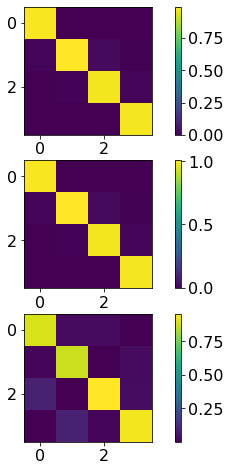

In [307]:
circs=[]
BACKEND=backend_sim_noisy_jakarta
depth=4
num_qubits=4
magn=2
qubits=[0,1]
shots=100000
x=np.random.rand(sym_ans(depth,num_qubits).num_parameters)*np.pi
qc_z=sym_ans(depth,num_qubits).assign_parameters(x)

backend=Aer.get_backend('aer_simulator')
meas_calibs, state_labels = qiskit_calibration_circuits(num_qubits,qubits_measure=qubits)
job_cal_aux = execute(meas_calibs, backend)
cal_results_aux = job_cal_aux.result()
cal_counts_aux=cal_results_aux.get_counts()
meas_fitter_aux = CompleteMeasFitter(cal_results_aux, state_labels)

qr=QuantumRegister(num_qubits)
qc=QuantumCircuit(qr)
qr_target=[]
for qubit in qubits:
  qr_target.append(qr[qubit])
for i in range (0,magn):
  qc.x(qr[i])
qc.append(qc_z,qr)
qc.measure_all()

circs.append(qc)
job_ideal=execute(qc,backend=Aer.get_backend('aer_simulator'),optimization_level=0,shots=100000)

qc_z=transpile(qc_z,BACKEND,optimization_level=0)

cal_circ_qiskit,state_labels=qiskit_calibration_circuits(num_qubits,qubits)
cal_circ_GEM,s_labels=GEM_calibration_circuits_symm(magn,num_qubits,depth,parameters=x,qubits_measure=qubits)
circs+=cal_circ_qiskit
circs+=cal_circ_GEM[0]
circs+=cal_circ_GEM[1]

job_noisy=execute(circs,backend=BACKEND,optimization_level=0,shots=shots)

noisy_counts=job_noisy.result().get_counts()
noisy_exp_counts=[]
for i,noisy in enumerate(noisy_counts):
  print(noisy)
  for key in noisy.keys():
    if(len(key)!=len(qubits)):
      if sum_string(key) != magn:
        noisy[key] = 0
    norm = sum(noisy.values())
    for key in noisy.keys():
      noisy[key] = noisy[key]/norm*shots
  print(noisy)
  noisy_exp_counts.append(marginal_counts(noisy, indices=qubits))
  print(noisy_exp_counts[i])
ideal_counts=job_ideal.result().get_counts()
ideal_counts=marginal_counts(ideal_counts, indices=qubits)
print(len(noisy_exp_counts))

job_qiskit=copy.deepcopy(cal_results_aux)
for i in range (0,len(state_labels)):
    job_qiskit.results[i].data.counts=noisy_exp_counts[1+i]
meas_fitter = CompleteMeasFitter(job_qiskit, state_labels)
job_GEM_L=copy.deepcopy(cal_results_aux)
job_GEM_R=copy.deepcopy(cal_results_aux)
for i in range (0,len(state_labels)):
    job_GEM_L.results[i].data.counts=meas_fitter.filter.apply(noisy_exp_counts[1+len(state_labels)+i],method="least_squares")
    job_GEM_R.results[i].data.counts=meas_fitter.filter.apply(noisy_exp_counts[1+2*len(state_labels)+i],method="least_squares")
meas_fitter_GEM_L = CompleteMeasFitter(job_GEM_L, state_labels=state_labels)
meas_fitter_GEM_R = CompleteMeasFitter(job_GEM_R, state_labels=state_labels)
Cal_GEM_L = meas_fitter_GEM_L.cal_matrix
Cal_GEM_R = meas_fitter_GEM_R.cal_matrix
print(Cal_GEM_R)
C=(Cal_GEM_L+Cal_GEM_R)/2
print(C)
rand_vec_prob=np.sum(C,axis=1,dtype='float')/(len(state_labels))
p_t=(C[0][0]-1)/(rand_vec_prob[0]-1)
rand_vec=p_t*shots*rand_vec_prob
print(rand_vec)
print(p_t)

D=np.zeros((len(state_labels),len(state_labels)))

for k in range (0,len(s_labels)):
    for j in range (0,len(s_labels)):
        D[k][j]=(C[k][j]-p_t*rand_vec_prob[k])/(1-p_t)

meas_fitter_GP=copy.deepcopy(meas_fitter_aux)
meas_fitter_GP.cal_matrix=D
meas_fitter_GEM=copy.deepcopy(meas_fitter_aux)
meas_fitter_GEM.cal_matrix=C

plt.figure(figsize=(8,8))
plt.subplot(311)
plt.imshow(C)
plt.colorbar()
plt.subplot(312)
plt.imshow(D)
plt.colorbar()
plt.subplot(313)
plt.imshow(meas_fitter.cal_matrix)
plt.colorbar()

noisy_exp_counts[0]=meas_fitter.filter.apply(noisy_exp_counts[0],method="least_squares")
qiskit_vector=occurrences_to_vector(noisy_exp_counts[0])


new_vector_CGP=(qiskit_vector-rand_vec)/(1-p_t)
print(new_vector_CGP)
new_counts=dict(zip(bin_list(len(qubits)),new_vector_CGP))
new_counts_CGP=meas_fitter_GP.filter.apply(new_counts,method="least_squares")
mitigated_counts_GEM=meas_fitter_GEM.filter.apply(noisy_exp_counts[0],method="least_squares")
mitigated_vector_GP=occurrences_to_vector(new_counts_CGP)
mitigated_vector_GEM=occurrences_to_vector(mitigated_counts_GEM)
energy_GP=mitigated_vector_GP[0]-mitigated_vector_GP[1]-mitigated_vector_GP[2]+mitigated_vector_GP[3]
energy_GEM=mitigated_vector_GEM[0]-mitigated_vector_GEM[1]-mitigated_vector_GEM[2]+mitigated_vector_GEM[3]

ideal_counts=occurrences_to_vector(ideal_counts)/100000
energy_ideal=ideal_counts[0]-ideal_counts[1]-ideal_counts[2]+ideal_counts[3]

print(energy_GP/shots)
print(energy_GEM/shots)
print(energy_ideal)







96
['00011', '00101', '00110', '01001', '01010', '01100', '10001', '10010', '10100', '11000']
['00', '01', '10', '11']
['01100', '00101', '00110', '00011']
['01100', '00101', '00110', '00011']
{'10011': 389, '01011': 359, '00000': 364, '10101': 338, '10000': 371, '01000': 508, '01111': 184, '11011': 88, '01110': 658, '00111': 763, '01100': 1977, '01101': 324, '00001': 340, '00110': 3853, '11110': 183, '11100': 320, '00010': 1160, '11101': 124, '10100': 528, '00100': 1154, '00011': 550, '11000': 492, '10111': 204, '11111': 67, '10110': 658, '10010': 684, '11010': 341, '11001': 166, '00101': 1098, '01001': 301, '01010': 1189, '10001': 265}
{'10011': 0.0, '01011': 0.0, '00000': 0.0, '10101': 0.0, '10000': 0.0, '01000': 0.0, '01111': 0.0, '11011': 0.0, '01110': 0.0, '00111': 0.0, '01100': 1807.6254914510382, '01101': 0.0, '00001': 0.0, '00110': 3522.9039041784754, '11110': 0.0, '11100': 0.0, '00010': 0.0, '11101': 0.0, '10100': 482.76492639663536, '00100': 0.0, '00011': 502.88013166316205,

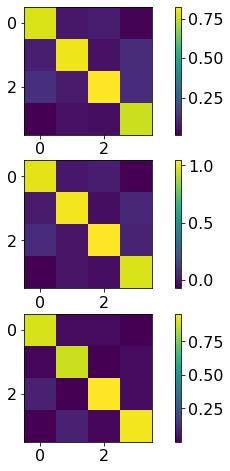

In [318]:
circs=[]
BACKEND=backend_sim_noisy_jakarta
depth=8
num_qubits=5
magn=2
qubits=[0,1]
shots=10000
shots_cal=20000
x=np.random.rand(sym_ans(depth,num_qubits).num_parameters)*2*np.pi
qc_z=sym_ans(depth,num_qubits).assign_parameters(x)

backend=Aer.get_backend('aer_simulator')
meas_calibs, state_labels = qiskit_calibration_circuits(num_qubits,qubits_measure=qubits)
job_cal_aux = execute(meas_calibs, backend)
cal_results_aux = job_cal_aux.result()
cal_counts_aux=cal_results_aux.get_counts()
meas_fitter_aux = CompleteMeasFitter(cal_results_aux, state_labels)

qr=QuantumRegister(num_qubits)
qc=QuantumCircuit(qr)
qr_target=[]
for qubit in qubits:
  qr_target.append(qr[qubit])
for i in range (0,magn):
  qc.x(qr[i])
qc.append(qc_z,qr)
qc.measure_all()

circs.append(qc)
job_ideal=execute(qc,backend=Aer.get_backend('aer_simulator'),optimization_level=0,shots=100000)

qc_z=transpile(qc_z,BACKEND,optimization_level=0)


cal_circ_GEM,s_labels=GEM_calibration_circuits_symm(magn,num_qubits,depth,parameters=x,qubits_measure=qubits)

circs+=cal_circ_GEM[0]
circs+=cal_circ_GEM[1]

job_noisy=execute(circs,backend=BACKEND,optimization_level=0,shots=shots_cal)
job_circ=execute(qc,backend=BACKEND,optimization_level=0,shots=shots)


noisy_counts=job_noisy.result().get_counts()
noisy_exp_counts[0]=job_circ.result().get_counts()
noisy_exp_counts=[]
for i,noisy in enumerate(noisy_counts):
  print(noisy)
  for key in noisy.keys():
    if(len(key)!=len(qubits)):
      if sum_string(key) != magn:
        noisy[key] = 0
    norm = sum(noisy.values())
    for key in noisy.keys():
      noisy[key] = noisy[key]/norm*shots
  print(noisy)
  noisy_exp_counts.append(marginal_counts(noisy, indices=qubits))
  print(noisy_exp_counts[i])
ideal_counts=job_ideal.result().get_counts()
ideal_counts=marginal_counts(ideal_counts, indices=qubits)
print(len(noisy_exp_counts))


job_GEM_L=copy.deepcopy(cal_results_aux)
job_GEM_R=copy.deepcopy(cal_results_aux)
for i in range (0,len(state_labels)):
    job_GEM_L.results[i].data.counts=noisy_exp_counts[1+i]
    job_GEM_R.results[i].data.counts=noisy_exp_counts[1+len(state_labels)+i]
meas_fitter_GEM_L = CompleteMeasFitter(job_GEM_L, state_labels=state_labels)
meas_fitter_GEM_R = CompleteMeasFitter(job_GEM_R, state_labels=state_labels)
Cal_GEM_L = meas_fitter_GEM_L.cal_matrix
Cal_GEM_R = meas_fitter_GEM_R.cal_matrix
print(Cal_GEM_R)
C=(Cal_GEM_L+Cal_GEM_R)/2
print(C)
rand_vec_prob=np.sum(C,axis=1,dtype='float')/(len(state_labels))
p_t=(C[0][0]-1)/(rand_vec_prob[0]-1)
rand_vec=p_t*shots*rand_vec_prob
print(rand_vec)
print(p_t)

D=np.zeros((len(state_labels),len(state_labels)))

for k in range (0,len(s_labels)):
    for j in range (0,len(s_labels)):
        D[k][j]=(C[k][j]-p_t*rand_vec_prob[k])/(1-p_t)

meas_fitter_GP=copy.deepcopy(meas_fitter_aux)
meas_fitter_GP.cal_matrix=D
meas_fitter_GEM=copy.deepcopy(meas_fitter_aux)
meas_fitter_GEM.cal_matrix=C

plt.figure(figsize=(8,8))
plt.subplot(311)
plt.imshow(C)
plt.colorbar()
plt.subplot(312)
plt.imshow(D)
plt.colorbar()
plt.subplot(313)
plt.imshow(meas_fitter.cal_matrix)
plt.colorbar()

#noisy_exp_counts[0]=meas_fitter.filter.apply(noisy_exp_counts[0],method="least_squares")
qiskit_vector=occurrences_to_vector(noisy_exp_counts[0])


new_vector_CGP=(qiskit_vector-rand_vec)/(1-p_t)
print(new_vector_CGP)
new_counts=dict(zip(bin_list(len(qubits)),new_vector_CGP))
new_counts_CGP=meas_fitter_GP.filter.apply(new_counts,method="least_squares")
mitigated_counts_GEM=meas_fitter_GEM.filter.apply(noisy_exp_counts[0],method="least_squares")
mitigated_vector_GP=occurrences_to_vector(new_counts_CGP)
mitigated_vector_GEM=occurrences_to_vector(mitigated_counts_GEM)
energy_GP=mitigated_vector_GP[0]-mitigated_vector_GP[1]-mitigated_vector_GP[2]+mitigated_vector_GP[3]
energy_GEM=mitigated_vector_GEM[0]-mitigated_vector_GEM[1]-mitigated_vector_GEM[2]+mitigated_vector_GEM[3]

ideal_counts=occurrences_to_vector(ideal_counts)/100000
energy_ideal=ideal_counts[0]-ideal_counts[1]-ideal_counts[2]+ideal_counts[3]

print(energy_GP/shots)
print(energy_GEM/shots)
print(energy_ideal)





